## Objective:

Develop a transformer-based model to solve a text classification problem.I will be using 🤗 library to fine-tune BERT model using Tensorflow.

Before executing the notebook please note:

1. To utlise the GPU kindly change runtime from default CPU to T4 GPU (for free version of collab) or to A100 for Pro users.

2. You would require a Kaggle API key to download the dataset, Incase you do not have one, manually download the dataset and upload in the notebook.

3. Code walkthrough chart can be found in the GitHub repository for better understanding of code.

## Installing required libraries and dependencies.

In [ ]:
import pandas as pd

!pip install opendatasets --q
import opendatasets as od

import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

!pip install transformers --q
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import accuracy_score


## Downloading and preparing the data set.

Data Source: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [ ]:
  od.download('https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sarthaksrivastava123
Your Kaggle Key: ··········


100%|██████████| 25.7M/25.7M [00:00<00:00, 106MB/s]


In [ ]:
df = pd.read_csv('/content/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<Axes: ylabel='sentiment'>

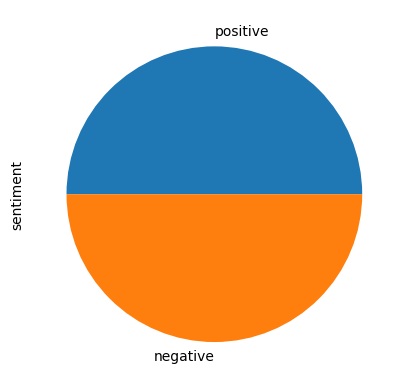

In [ ]:
#Checking Distribution
df['sentiment'].value_counts().plot(kind='pie')

Intial Observations:
- Irregular Uppercasing and lowercasing.
- Reviews may contain HTML tags.

In [ ]:
#Basic Data Cleaning

#Lowercasing

df['review'] = df['review'].str.lower()

#Removing HTML tags, as data scrapped it may contain HTML tags

def remove_html_tags(text):
	pattern = re.compile('<.*?>')  #This will remove anything that stats with a angular bracket.
	return pattern.sub(r'', text)

df['review'] = df['review'].apply(remove_html_tags)

With this we conclude our basic cleaning.

## Train Test Split

That dataset is very large i.e containing 50,000 reviews, however Large Languge Models do not require this much data for fine tuning hence , I have reduced the data size significantly to 6000.

While spliting I have used startify=y so that the splitting process will maintain the proportion of positive and negative reviews in the original dataset when creating the training and testing subsets.

In [ ]:
#NOTE: I have specified 0 for a positive review, and 1 for negative.
df['sentiment'].replace('positive', 0, inplace=True)
df['sentiment'].replace('negative', 1, inplace=True)

X = df['review'][0:6000]
y = df['sentiment'][0:6000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

## Tokenization and Model Selection

We would be using BERT-base model. Hence we would use the model specific tokenizer.

The labels (Train and Test i.e. postive or negative) can be easily converted into tensors.

The reviews will require embedding, attention mask and input ids. This wil be taken care by the tokenizer itself.

In [ ]:
model_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tokenized_inputs = tokenizer(X_train.tolist(), truncation=True, padding=True, return_tensors="tf")
labels = tf.convert_to_tensor(y_train.tolist())
test_labels = tf.convert_to_tensor(y_test.tolist())

In [ ]:
# Calling the model and specifing that output class has two values ie. 0 and 1.
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Model Training

In [ ]:
%%time

# Convert BatchEncoding to dictionaries
tokenized_inputs_dict = {key: val.numpy() for key, val in tokenized_inputs.items()}

# Create a TensorFlow dataset
tf_dataset = tf.data.Dataset.from_tensor_slices((tokenized_inputs_dict, labels))

# Adjust batch size and shuffling
batch_size = 10
shuffle_buffer_size = 100  # Set to the number of samples for a full shuffle
tf_dataset = tf_dataset.shuffle(shuffle_buffer_size).batch(batch_size)

# Prefetch for better performance
tf_dataset = tf_dataset.prefetch(tf.data.experimental.AUTOTUNE)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train the model
epochs = 10
model.fit(tf_dataset, epochs=epochs)

Epoch 1/10
480/480 [==============================] - 631s 1s/step - loss: 0.3481 - accuracy: 0.8400
Epoch 2/10
480/480 [==============================] - 588s 1s/step - loss: 0.1554 - accuracy: 0.9433
Epoch 3/10
480/480 [==============================] - 587s 1s/step - loss: 0.0836 - accuracy: 0.9717
Epoch 4/10
480/480 [==============================] - 588s 1s/step - loss: 0.0563 - accuracy: 0.9823
Epoch 5/10
480/480 [==============================] - 588s 1s/step - loss: 0.0379 - accuracy: 0.9865
Epoch 6/10
480/480 [==============================] - 587s 1s/step - loss: 0.0258 - accuracy: 0.9910
Epoch 7/10
480/480 [==============================] - 587s 1s/step - loss: 0.0215 - accuracy: 0.9925
Epoch 8/10
480/480 [==============================] - 587s 1s/step - loss: 0.0196 - accuracy: 0.9935
Epoch 9/10
480/480 [==============================] - 587s 1s/step - loss: 0.0156 - accuracy: 0.9956
Epoch 10/10
480/480 [==============================] - 587s 1s/step - loss: 0.0255 - accura

In [ ]:
tokenized_test_inputs = tokenizer(X_test.tolist(), truncation=True, padding=True, return_tensors="tf")
test_inputs_dict = {key: val.numpy() for key, val in tokenized_test_inputs.items()}

predictions = model.predict(test_inputs_dict)
print('Predictions made')

class_labels = model.config.id2label
print(class_labels)

probabilities = tf.nn.softmax(predictions.logits, axis=-1) #Converting logits into probabilty
predicted_classes = tf.argmax(probabilities, axis=-1) #Converting into Single Column

38/38 [==============================] - 57s 1s/step
Predictions made
{0: 'LABEL_0', 1: 'LABEL_1'}


## Results

In [ ]:
accuracy = accuracy_score(test_labels, predicted_classes)
print(f"Accuracy of the model is {accuracy}")

Accuracy of the model is 0.9016666666666666


In [ ]:
model.save_pretrained('fine_tuned_bert_model')
tokenizer.save_pretrained('fine_tuned_bert_model')

('fine_tuned_bert_model/tokenizer_config.json',
 'fine_tuned_bert_model/special_tokens_map.json',
 'fine_tuned_bert_model/vocab.txt',
 'fine_tuned_bert_model/added_tokens.json')

## Conclusion:

* The model scored an accuracy of 90.16%
* The last epoch reported loss: 0.0255 - accuracy: 0.9919
* Due to lack of computational power and large data set, I have to train model for less number of epochs.
* Traing with some more data and more epochs can easily increase the accuracy.
* The maximum batch size I could go for was 10 (for google collab free version)
* With batch_size of 10 the GPU consumption was arouNd 14GB/15GB.
* **This notebook takes almost 1hr 40 mins to run end to end. (On free version of Google Collab) Increase in batch size and more availability of RAM can reduce this time.**